### Import libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft # For the fourier transform
from scipy.interpolate import griddata # For the interpolation
from scipy.optimize import curve_fit

### Define functions

- `load_data` takes in a DEM in .txt form and outputs a numpy array of x, y, z vectors
- `interpolate` takes in an unsorted array of points and fits the data to a regular grid (reconstructs DEM)
- `psd` computes the average power series density (PSD) of each row ($\pm x$ direction) of the input grid
- `plot_psd_log` plots the PSD against the corresponding wavenumbers in log-log space and computes the Hurst exponent

In [37]:
def load_data(path):
    """
    Loads the data from a text file. 
    Columns 1, 2, 3 should be the x, y, z coordinates respectively.
    The separator should be a space.
    Slip direction should be aligned in the x direction.
    The normal direction should be aligned in the z direction.

    Input:
    path: The path to the text file.

    Output:
    data: The data from the text file.
    """

    data = np.loadtxt(path, usecols=(0,1,2)) # Only x, y, z coordinates
    return data

def interpolate(raw_data):
    """
    Interpolates the data onto a regular grid.

    Input:
    raw_data: The raw data to be interpolated. 
    Should be a numpy array with 3 columns, where the first two columns are the x and y coordinates, 
    and the third column is the z coordinate.

    Output:
    fit_data: Data interpolated onto a regular grid.
    """
    
    # write a comment 

    # Spacing of the grid
    # Calculated by taking the difference between the first two points
    x_spacing = abs(round((raw_data[1,0] - raw_data[2,0]) / 1, 3)) # Round to 2 decimal places
    y_spacing = abs(round(raw_data[0,1] - raw_data[4,1], 3))

    print(f'x_spacing = {x_spacing}, y_spacing = {y_spacing}')

    # Length of the grid in x and y
    # Calculated by taking the difference between the first and last points
    x_max, x_min = np.max(raw_data[:,0]), np.min(raw_data[:,0])
    y_max, y_min = np.max(raw_data[:,1]), np.min(raw_data[:,1])

    x_length = abs(round(x_max - x_min, 3))
    y_length = abs(round(y_max - y_min, 3))

    # # Create histogram of the distance between each point
    # # This is to check that the spacing is consistent
    # print(np.mean(np.absolute(np.diff(raw_data[:,0]))), np.std(np.absolute(np.diff(raw_data[:,0]))))
    # print(np.mean(np.absolute(np.diff(raw_data[:,1]))), np.std(np.absolute(np.diff(raw_data[:,1]))))

    # # print number of distances that are greater than 0.15
    # print(np.sum(np.absolute(np.diff(raw_data[:,0])) > 0.15) / len(raw_data[:,0]))

    # plt.hist(np.absolute(np.diff(raw_data[:,0])), bins=100, range=(0.05, 0.2))
    # plt.show()

    x_spacing = 0.1
    y_spacing = 0.01

    x_spacing = abs(round(raw_data[0,0] - raw_data[1,0], 3)) # Round to 2 decimal places
    y_spacing = abs(round(raw_data[0,1] - raw_data[1,1], 3))

    # Create a regular grid using meshgrid
    # Here, length // spacing = number of points
    x = np.linspace(x_min, x_max, int(x_length // x_spacing)) 
    y = np.linspace(y_min, y_max, int(y_length // y_spacing))
    X, Y = np.meshgrid(x, y)

    # Interpolate the data onto the grid
    # fit_data[0] is the bottom row, fit_data[-1] is the top row. fit_data[:,0] is the left column, fit_data[:,-1] is the right column. 
    # Index row by row by going from fit_data[0] to fit_data[-1] for fft.
    fit_data = griddata(raw_data[:,0:2], raw_data[:,2], (X, Y), method='linear')

    # Remove any NaN values by replacing them with the mean of the data
    fit_data = np.nan_to_num(fit_data, nan=np.nanmean(fit_data))

    # Plot the data
    plt.contourf(X, Y, fit_data, 100, cmap='jet')
    plt.colorbar()
    plt.show()

    print(fit_data.shape)

    return fit_data

def psd(data_array):
    """
    Performs an FFT row by row on the input array. Each FFT output is then converted to PSD as a function of wavenumber (1 / frequency).
    
    """

    # Perform the FFT on each row
    fft_data = np.fft.fft(data_array, axis=1)
    
    # Calculate the PSD from the FFT data (only the real part is needed)
    psd_data = np.abs(fft_data)**2

    # Take the mean psd of all the rows
    psd_data = np.mean(psd_data, axis=0)
    
    # Calculate the wavenumber (reciprocal of frequency)
    # The wavenumber is the same for each row, so we can just calculate it once
    wavenumber = np.fft.fftfreq(len(data_array[0]))

    # Remove the negative (and 0) wavenumbers and corresponding psd data
    # This is because 1) the PSD is symmetry about 0 and 
    # 2) We have to take the log of each value later
    psd_data = psd_data[wavenumber > 0]
    wavenumber = wavenumber[wavenumber > 0]
    
    return wavenumber, psd_data


def interpolate_psd(raw_data):
    """
    Combines the interpolate and psd functions
    Experimental
    """

    """
    ---------------------INTERPOLATION---------------------
    """
    # Spacing of the grid
    # Calculated by taking the difference between the first two points
    x_spacing = abs(round((raw_data[0,0] - raw_data[5,0]) / 4, 3)) # Round to 2 decimal places
    y_spacing = abs(round(raw_data[0,1] - raw_data[3,1], 3))

    print(f'x_spacing = {x_spacing}, y_spacing = {y_spacing}')

    print(np.mean(np.absolute(np.diff(raw_data[:,0]))))
    print(np.mean(np.absolute(np.diff(raw_data[:,1]))))

    # Length of the grid in x and y
    # Calculated by taking the difference between the first and last points
    x_max, x_min = np.max(raw_data[:,0]), np.min(raw_data[:,0])
    y_max, y_min = np.max(raw_data[:,1]), np.min(raw_data[:,1])

    x_length = abs(round(x_max - x_min, 3))
    y_length = abs(round(y_max - y_min, 3))

    x_spacing = 0.1
    y_spacing = 0.1

    # Create a regular grid using meshgrid
    # Here, length // spacing = number of points
    x = np.linspace(x_min, x_max, int(x_length // x_spacing)) 
    y = np.linspace(y_min, y_max, int(y_length // y_spacing))
    X, Y = np.meshgrid(x, y)

    # Interpolate the data onto the grid
    # fit_data[0] is the bottom row, fit_data[-1] is the top row. fit_data[:,0] is the left column, fit_data[:,-1] is the right column
    # Index row by row by going from fit_data[0] to fit_data[-1] for fft
    # Fill any NaN values with the mean of the data
    fit_data = griddata(raw_data[:,0:2], raw_data[:,2], (X, Y), method='linear', fill_value=np.nanmean(raw_data[:,2]))

    # Plot the data
    plt.contourf(X, Y, fit_data, 100, cmap='jet')
    plt.colorbar()
    plt.show()

    print(fit_data.shape)

    """ 
    ---------------------PSD---------------------
    """

    # Perform the FFT on each row
    fft_data = np.fft.fft(fit_data, axis=1)
    
    # Calculate the PSD from the FFT data (only the real part is needed)
    psd_data = np.abs(fft_data)**2

    # Take the mean psd of all the rows
    psd_data = np.mean(psd_data, axis=0)
    
    # Calculate the wavenumber (reciprocal of frequency)
    # The wavenumber is the same for each row, so we can just calculate it once
    wavenumber = np.fft.fftfreq(len(fit_data[0]))

    # Remove the negative (and 0) wavenumbers and corresponding psd data
    # This is because 1) the PSD is symmetry about 0 and 
    # 2) We have to take the log of each value later
    psd_data = psd_data[wavenumber > 0]
    wavenumber = wavenumber[wavenumber > 0]

    # Drop wavelengths shorter than 0.5mm (5 units of 0.1 x_spacing)
    psd_data = psd_data[1 / wavenumber > 5]
    wavenumber = wavenumber[1 / wavenumber > 5]

    # # Drop wavelengths longer than half the length of the grid
    psd_data = psd_data[1 / wavenumber < (x_length / x_spacing / 2)]
    wavenumber = wavenumber[1 / wavenumber < (x_length / x_spacing / 2)]
    
    return wavenumber, psd_data


def plot_psd_log(wavenumber, psd_data):
    """
    Plots the PSD data as a function of wavenumber on a log-log scale.

    Input:
    wavenumber: The wavenumber data.
    psd_data: The PSD data.
    """

    def hurst(wv, ps):
        """
        Hurst Exponent
        """
        # Fit a line to the log of the data
        def func(x, a, b): return a*x + b # Linear function
        popt, pcov = curve_fit(func, np.log(wv), np.log(ps)) # Fit

        # Calculate the Hurst exponent (slope + 1) / -2
        hurst = (popt[0] + 1) / -2

        # Calculate error
        perr = np.sqrt(np.diag(pcov))

        return hurst, perr[0]

    if isinstance(wavenumber[0], np.ndarray): # If the wavenumber is a 2D array, i.e. multiple scans
        # Plot each scan on the same plot

        for i in range(len(wavenumber)):
            hurst_exp, hurst_err = hurst(wavenumber[i], psd_data[i])
            plt.scatter(wavenumber[i], psd_data[i], label=f'Scan {i+1}, HE= {round(hurst_exp, 3)} +/- {round(hurst_err, 3)}')

        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Wavenumber')
        plt.ylabel('PSD')
        plt.title('PSD as a function of wavenumber')
        plt.legend()
        plt.show()
        
    else:

        hurst_exp, hurst_err = hurst(wavenumber, psd_data)
        print(hurst_exp, hurst_err)

        plt.scatter(wavenumber, psd_data)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Wavenumber')
        plt.ylabel('PSD')
        plt.title('PSD as a function of wavenumber')
        plt.show()


### Execute (Will be streamlined later)

#### Single scan

x_spacing = 0.103, y_spacing = 0.074
0.20581092957517988
0.09261790514830884


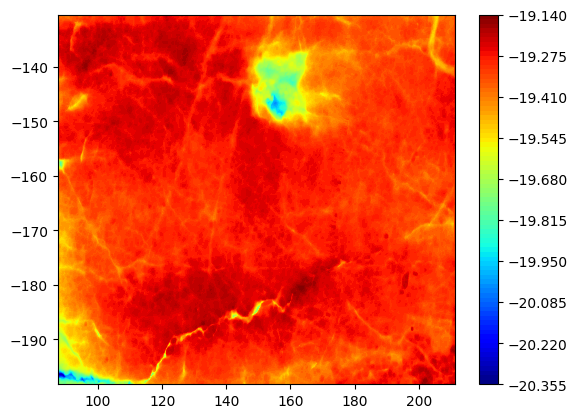

(6773, 1237)
0.6894764012665906 0.02038967792156943


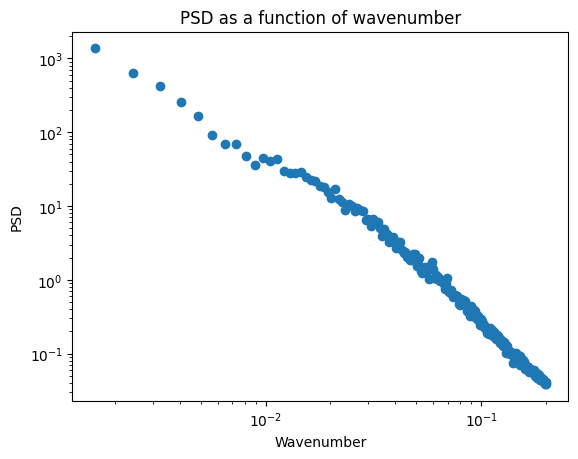

In [39]:
# Load data
path = '../surfaces/AVLY03/AVLY03_large.txt'
data = load_data(path)

# Compute
# a = interpolate(data)


wn, ps = interpolate_psd(data)


plot_psd_log(wn, ps)

#### Multiple scans

In [13]:
# List of files
prefix = '../surfaces/'
suffix = '.txt'
file_list = ['AVLY01/AVLY01_S1', 'AVLY01/AVLY01_S2', 'AVLY02/AVLY02', 'AVLY03/AVLY03', 'AVLY04/AVLY04', 'AVLY05/AVLY05']

# Initiate lists
name_list = []
wn_list = []
psd_list = []
hurst_list = []

# Load data 
for file in file_list:
    path = prefix + file + suffix
    data = load_data(path)

    # Compute
    wn, ps = interpolate_psd(data)

    # Append to lists
    name_list.append(file)
    wn_list.append(wn)
    psd_list.append(ps)

x_spacing = 0.131, y_spacing = 0.016
0.1959644006679587
0.10178272006254682
(4262, 1264)
x_spacing = 0.128, y_spacing = 0.023
0.15722191815232262
0.078171025649634
(5167, 1234)
x_spacing = 0.102, y_spacing = 0.002
0.19899422198953176
0.00578702355987369
(3485, 559)
x_spacing = 0.124, y_spacing = 0.041
0.21223296609369907
0.0859631123822651
(6818, 1378)
x_spacing = 0.033, y_spacing = 0.132
0.07981333908294266
0.18313082844089532
(4033, 671)
x_spacing = 0.124, y_spacing = 0.042
0.21311199112815307
0.07590881444068673
(8359, 756)


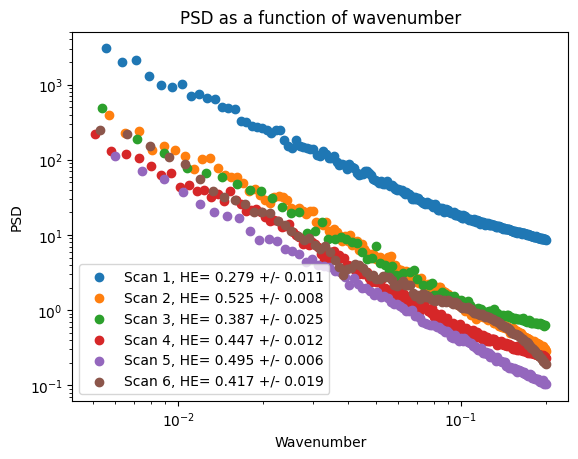

In [36]:
new_wn = [0, 0, 0, 0, 0, 0]
new_ps = [0, 0, 0, 0, 0, 0]

# cut off wn and psd at 0.1 
for i in range(len(wn_list)):
    new_wn[i] = wn_list[i][wn_list[i] < 0.03] # Right bound
    new_ps[i] = psd_list[i][wn_list[i] < 0.03]

    new_wn[i] = wn_list[i][wn_list[i] > 0.005] # Left bound
    new_ps[i] = psd_list[i][wn_list[i] > 0.005]



plot_psd_log(new_wn, new_ps)

#### legacy

x_spacing = 0.104, y_spacing = 0.022


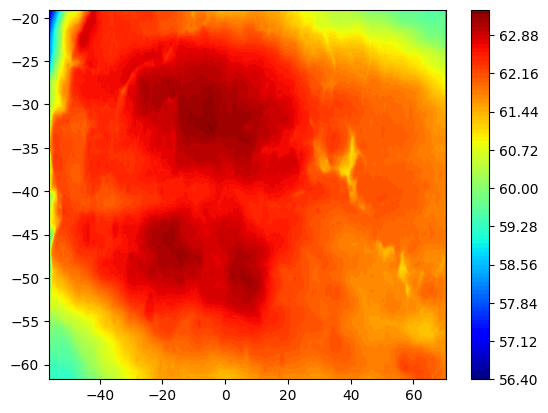

(8524, 1149)
x_spacing = 0.105, y_spacing = 0.029


In [5]:
# List of files
prefix = '../surfaces/'
suffix = '.txt'
file_list = ['AVLY01/AVLY01_S1', 'AVLY01/AVLY01_S2', 'AVLY02/AVLY02', 'AVLY03/AVLY03', 'AVLY04/AVLY04', 'AVLY05/AVLY05']

# Initiate lists
name_list = []
wn_list = []
psd_list = []
hurst_list = []

# Load data 
for file in file_list:
    path = prefix + file + suffix
    data = load_data(path)

    # Compute
    fit_data = interpolate(data)
    wn, ps = psd(fit_data)

    ps = ps[1 / wn > 50]
    wn = wn[1 / wn > 50]

    # Append to lists
    name_list.append(file)
    wn_list.append(wn)
    psd_list.append(ps)

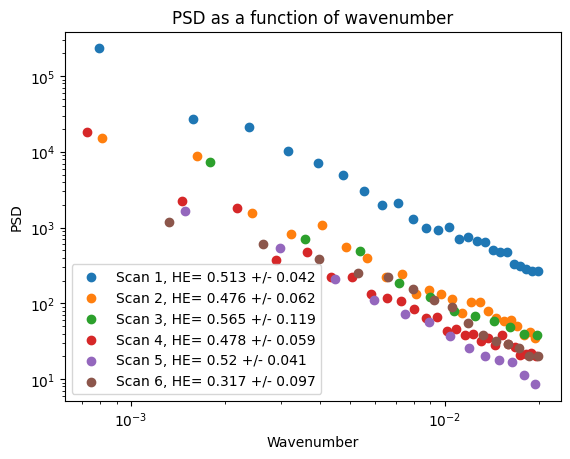

In [ ]:
plot_psd_log(wn_list, psd_list)

In [ ]:
def plot_fourier(data_array):
    # Plot the fourier transform of the data
    fft_data = np.fft.fft(data_array, axis=1)

    # Take the mean of all the rows
    fft_data = np.mean(fft_data, axis=0)

    # Calculate the wavenumber (reciprocal of frequency)
    # The wavenumber is the same for each row, so we can just calculate it once
    wavenumber = np.fft.fftfreq(len(data_array[0]))

    fft_data = fft_data[wavenumber > 0]
    wavenumber = wavenumber[wavenumber > 0]

    # Only real part
    fft_data = np.abs(fft_data)

    plt.plot(wavenumber, fft_data)
    plt.xlim(0, 0.1)
    
    plt.show()


plot_fourier(gridded_data) # Plot the fourier transform of the data

NameError: name 'gridded_data' is not defined